In [43]:
import os
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpecFromSubplotSpec
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
from tqdm import tqdm
pd.set_option('mode.chained_assignment', None)

_EEG_RAW_COLNAMES = {
    'RAW_TP9':'TP9', 
    'RAW_TP10':'TP10', 
    'RAW_AF7':'AF7', 
    'RAW_AF8':'AF8'
}
_EEG_MUSE_COLNAMES = [
    'Delta_TP9','Delta_TP10','Delta_AF7','Delta_AF8',
    'Theta_TP9', 'Theta_TP10', 'Theta_AF7', 'Theta_AF8',
    'Alpha_TP9', 'Alpha_TP10', 'Alpha_AF7', 'Alpha_AF8',
    'Beta_TP9', 'Beta_TP10', 'Beta_AF7', 'Beta_AF8',
    'Gamma_TP9', 'Gamma_TP10', 'Gamma_AF7', 'Gamma_AF8'
]

class Experiment:
    def __init__(self, root_dir:str, verbose:bool=False):
        # Self-initialization, finding sessions
        self.root_dir = root_dir
        self.subdirectories = self.find_subdirectories(self.root_dir)
        if verbose:
            print("IDENTIFIED SUBDIRECTORIES:")
            for f in self.subdirectories: 
                print('└──', f)
    def initialize_sessions(self, eeg_filename:str, gaze_filename:str, calibration_filenames, verbose:bool=False, start_buffer:int=5000, end_buffer:int=1000):
        if verbose: print("INITIALIZING SUBDIRECTORIES AS SESSIONS")
        pbar = tqdm(self.subdirectories)
        self.sessions = []
        for f in pbar:
            pbar.set_description(os.path.basename(f))
            s = Session(self, f, eeg_filename, gaze_filename, calibration_filenames)
            s.initialize_calibrations(start_buffer=start_buffer, end_buffer=end_buffer)
            self.sessions.append(s)
        return self
    
    @staticmethod
    def find_subdirectories(dir:str):
        subdirs = [ f.path for f in os.scandir(dir) if f.is_dir() ]
        return sorted(subdirs)



class Session:
    def __init__(self, parent:Experiment, root_dir:str, eeg_filename:str, gaze_filename:str, calibration_filenames):
        self.parent = parent
        self.root_dir = root_dir
        self.eeg_raw, self.eeg_muse, self.eeg_blinks = self.read_eeg(os.path.join(root_dir, eeg_filename))
        self.gaze_raw = pd.read_csv(os.path.join(root_dir, gaze_filename))
        self.calibrations_raw = [(Path(f).stem, pd.read_csv(os.path.join(root_dir, f))) for f in calibration_filenames]
    def initialize_calibrations(self, start_buffer:int=5000, end_buffer:int=1000):
        self.calibrations = []
        pbar = tqdm(self.calibrations_raw)
        for c in pbar:
            pbar.set_description(c[0])
            self.calibrations.append(Calibration(self, c[1], start_buffer=start_buffer, end_buffer=end_buffer))
    def plot_raw_calibrations(self):
        fig = plt.figure(figsize=(30, len(self.calibrations)))
        subplots = fig.add_gridspec(1, len(self.calibrations))
        # Embed your 2-row plot in the bottom-right quadrant
        for i in range(len(self.calibrations)):
            c = self.calibrations[i]
            c.plot_raw_data(parent_spec=subplots[i])
        plt.show()

    @staticmethod
    def timestamp_to_unix_seconds(x):
        date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
        unix_seconds = datetime.datetime.timestamp(date_format)
        return unix_seconds
    @staticmethod
    def timestamp_to_unix_milliseconds(x):
        date_format = datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")
        unix_seconds = datetime.datetime.timestamp(date_format)
        unix_milliseconds = int(unix_seconds * 1000)
        return unix_milliseconds
    @classmethod
    def read_eeg(cls, filepath:str):
        # Assertion to check file existence
        assert os.path.exists(filepath), f'EEG file {filepath} does not exist...'
        # Initial read
        df = pd.read_csv(filepath)
        # Generate timestamp features
        df['unix_ms'] = df['TimeStamp'].apply(cls.timestamp_to_unix_milliseconds)
        df['unix_sec'] = df['TimeStamp'].apply(cls.timestamp_to_unix_seconds)    
        df['rel_sec'] = df['unix_sec'] - df['unix_sec'].iloc[0]
        df['rel_ms'] = df['unix_ms'] - df['unix_ms'].iloc[0] 
        # separate blinks from raw data
        signals = df[df['Elements'].isna()]
        blinks = df[df['Elements']=='/muse/elements/blink']
        blinks = blinks[['TimeStamp', 'unix_sec', 'unix_ms', 'rel_sec', 'rel_ms']]    
        # Get raw data, then rename the features
        raw_df = signals[['unix_sec','unix_ms', 'rel_sec', 'rel_ms', *list(_EEG_RAW_COLNAMES.keys())]]
        raw_df.rename(columns=_EEG_RAW_COLNAMES, inplace=True)
        # Get processed data
        processed_df = signals[['unix_sec','unix_ms', 'rel_sec', 'rel_ms', *_EEG_MUSE_COLNAMES]]
        # return 
        return raw_df, processed_df, blinks

class Calibration:
    def __init__(self, parent:Session, df:pd.DataFrame, start_buffer:int=5000, end_buffer:int=1000):
        self.parent = parent
        # Get start and end timestamps
        self.start = df.loc[df["event"] == "Start"].iloc[0]
        if start_buffer is not None: 
            self.start['unix_ms'] += start_buffer   # Append buffer time (in milliseconds) to reduce time clutter
        self.end = df.loc[df["event"] == "End"].iloc[0]
        if end_buffer is not None: 
            self.end['unix_ms'] -= end_buffer       # Append buffer time (in milliseconds) to reduce time clutter
        # Get overlap times
        self.overlaps = df[df['event'] == 'Overlap']
        # Get gaze and EEG corresponding to start and end times
        self.eeg = parent.eeg_raw[parent.eeg_raw['unix_ms'].between(self.start['unix_ms'], self.end['unix_ms'])]
        self.gaze = parent.gaze_raw[parent.gaze_raw['unix_ms'].between(self.start['unix_ms'], self.end['unix_ms'])]

    # CALLING THIS DOES NOT ACTUALLY PRODUCE A PLOT. CALL `Calibration.plot()`, THEN `plt.show()` IN THE NEXT LINE
    def plot_raw_data(self, parent_spec=None):
        # Define a grid spec that we'll render into. If standalone (e.g. no parent_spec), we create a spec ourselves
        if parent_spec is None:
            fig = plt.figure(figsize=(6, 3))
            parent_spec = fig.add_gridspec(1, 1)[0]
        else:
            fig = plt.gcf()
        # Define our subplot within our spec, which is two rows and one column subplots
        gs = GridSpecFromSubplotSpec( 2, 1, subplot_spec=parent_spec, hspace=0.1 )
        # Define our axes
        ax_top = fig.add_subplot(gs[0])
        ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)
        # Plot
        ax_top.plot(self.eeg['unix_ms'], self.eeg['TP9'], color='lightblue', label='RAW TP9')
        ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False )
        ax_bottom.plot(self.gaze['unix_ms'], self.gaze['left_screen_pos_y'], color='red', label='L. Eye Y-pos')
        # Legend
        ax_top.legend()
        ax_bottom.legend()
        # Render vertical lines to represent calibration starts
        ax_top_trans = mtransforms.blended_transform_factory(
            ax_top.transData,   # x in data coordinates
            ax_top.transAxes    # y in axes coordinates
        )
        ax_bottom_trans = mtransforms.blended_transform_factory(
            ax_bottom.transData,   # x in data coordinates
            ax_bottom.transAxes    # y in axes coordinates
        )
        for row_index, row in self.overlaps.iterrows():
            ax_top.axvline(x=row['unix_ms'], color='black', alpha=0.75)
            ax_top.text( row['unix_ms'], 0.02, f"Start {row['overlap_counter']}",
                            transform=ax_top_trans, rotation=90, ha='left', va='bottom', fontsize=6, rotation_mode='anchor')
            ax_bottom.axvline(x=row['unix_ms'], color='black', alpha=0.75)
            ax_bottom.text(row['unix_ms'], 0.02, f"Start {row['overlap_counter']}", 
                            transform=ax_bottom_trans, rotation=90, ha='left', va='bottom', fontsize=6, rotation_mode='anchor')
        # Return
        return ax_top, ax_bottom

In [44]:
_CAL_FILES = [
    '0.25-72.csv', '0.25-90.csv',
    '0.5-72.csv', '0.5-90.csv',
    '0.75-72.csv', '0.75-90.csv'
]
_ROOT_DIR = os.path.join('.','samples','blink_calibration')
experiment = Experiment(_ROOT_DIR, verbose=True)
experiment.initialize_sessions('eeg.csv', 'left_eye_gaze.csv', _CAL_FILES, start_buffer=4000, end_buffer=0)


IDENTIFIED SUBDIRECTORIES:
└── ./samples/blink_calibration/1.Android_1
└── ./samples/blink_calibration/2.Android_2
└── ./samples/blink_calibration/3.Android_3
└── ./samples/blink_calibration/4.iPhone_1
└── ./samples/blink_calibration/5.iPhone_2
└── ./samples/blink_calibration/6.iPhone_3


6.iPhone_3: 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


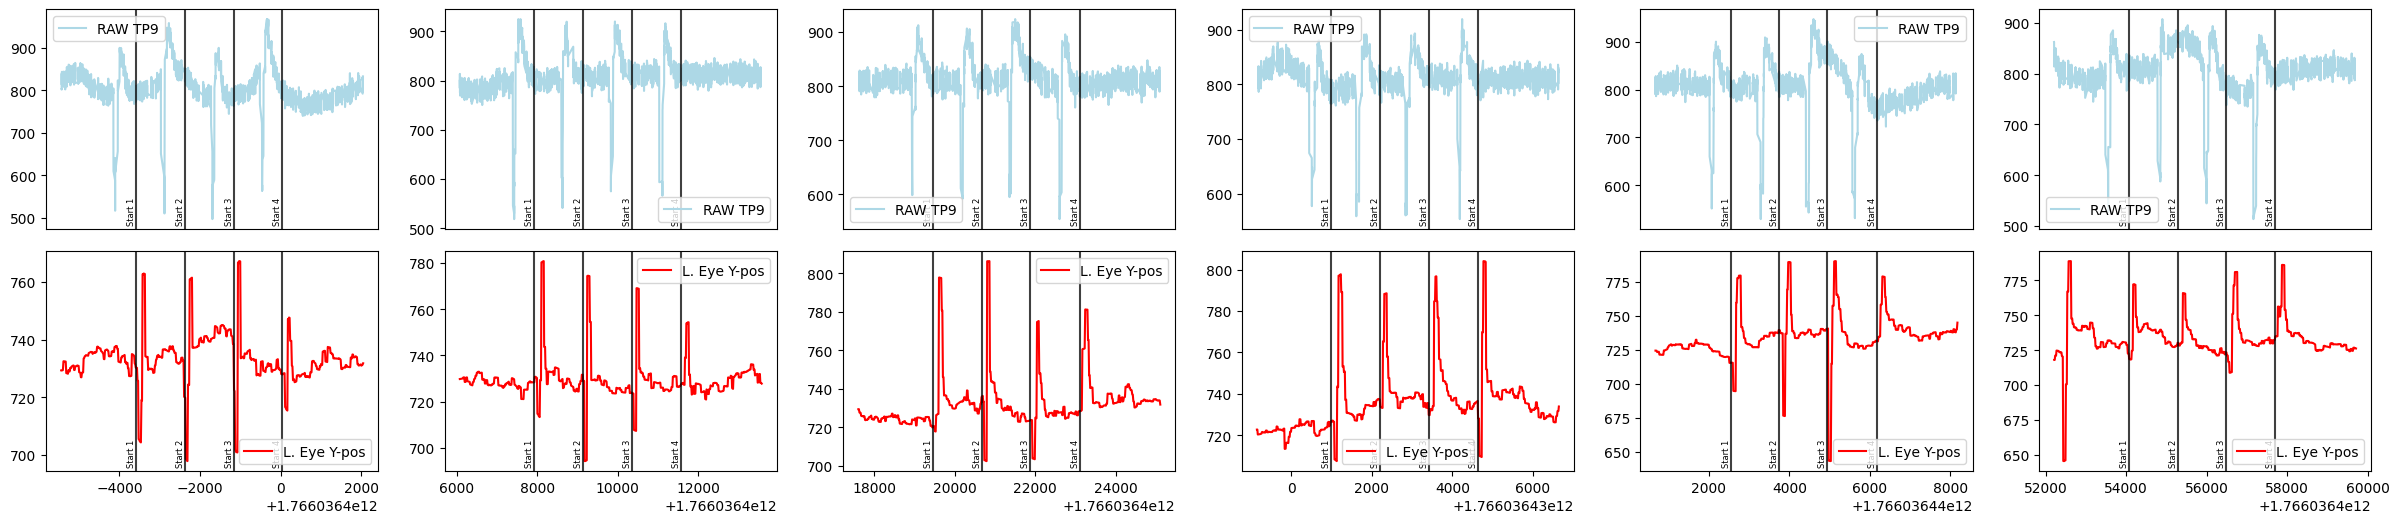

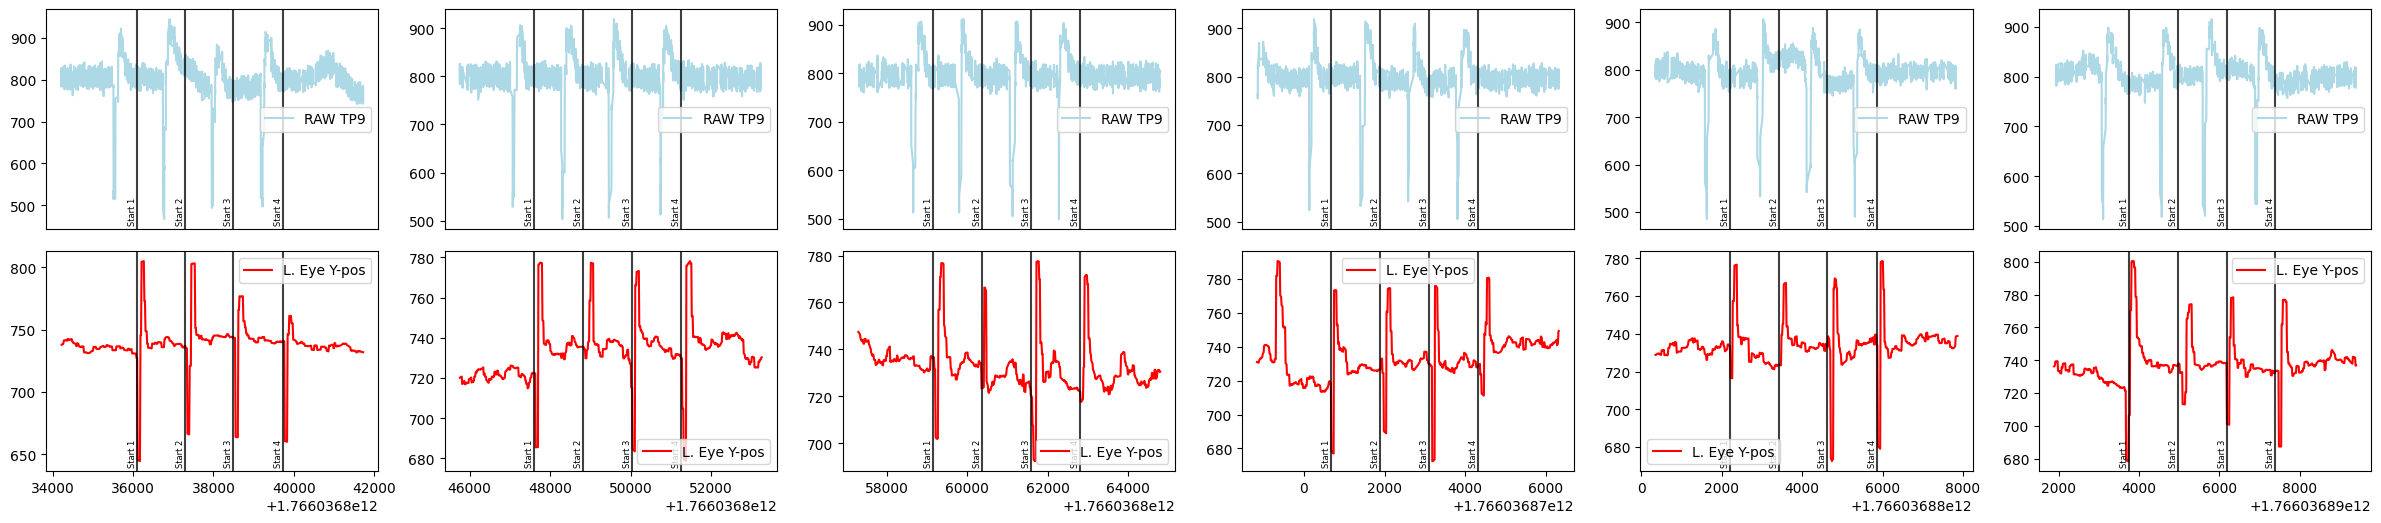

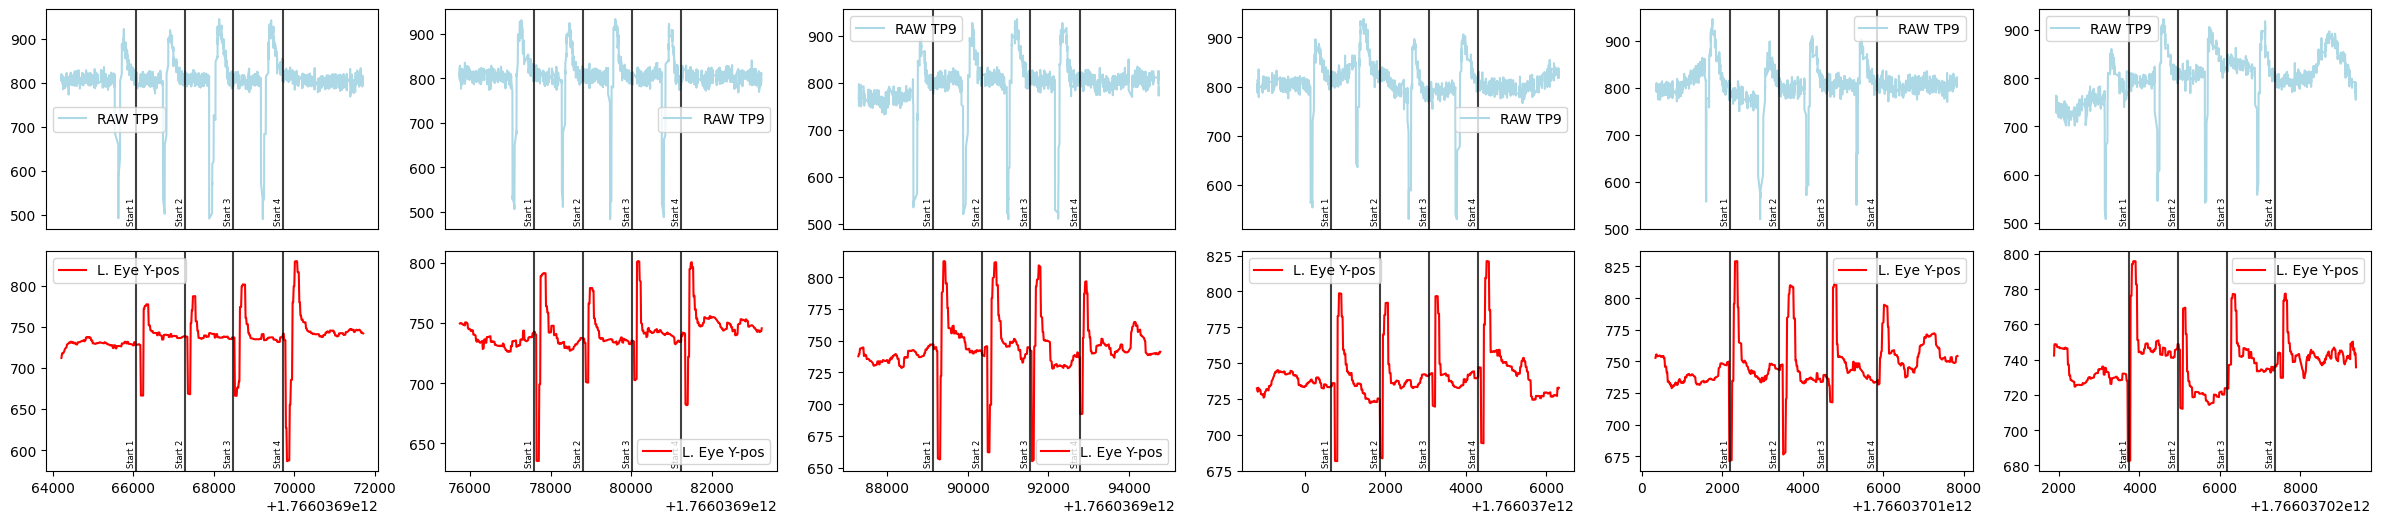

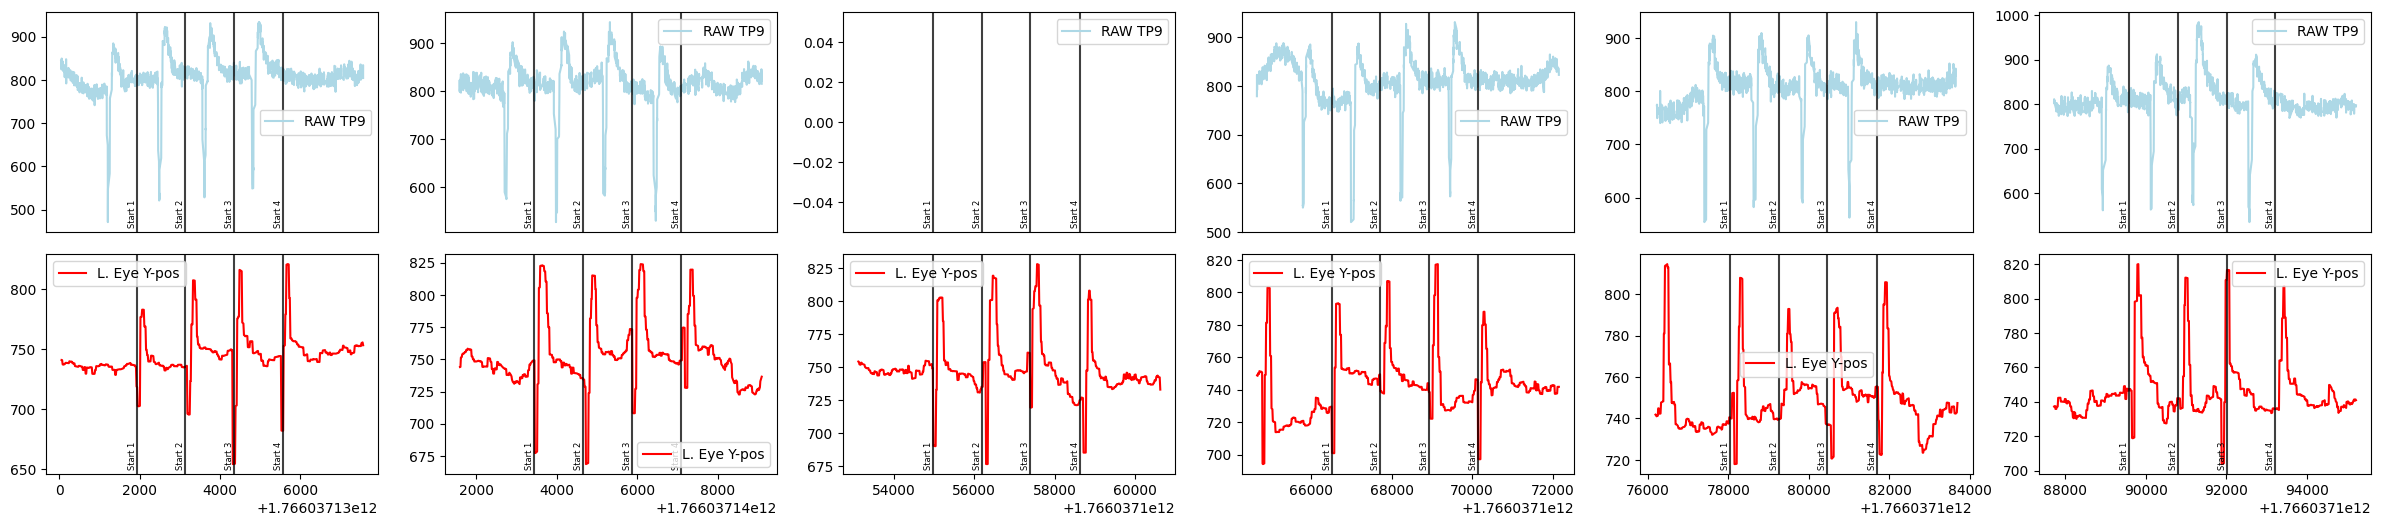

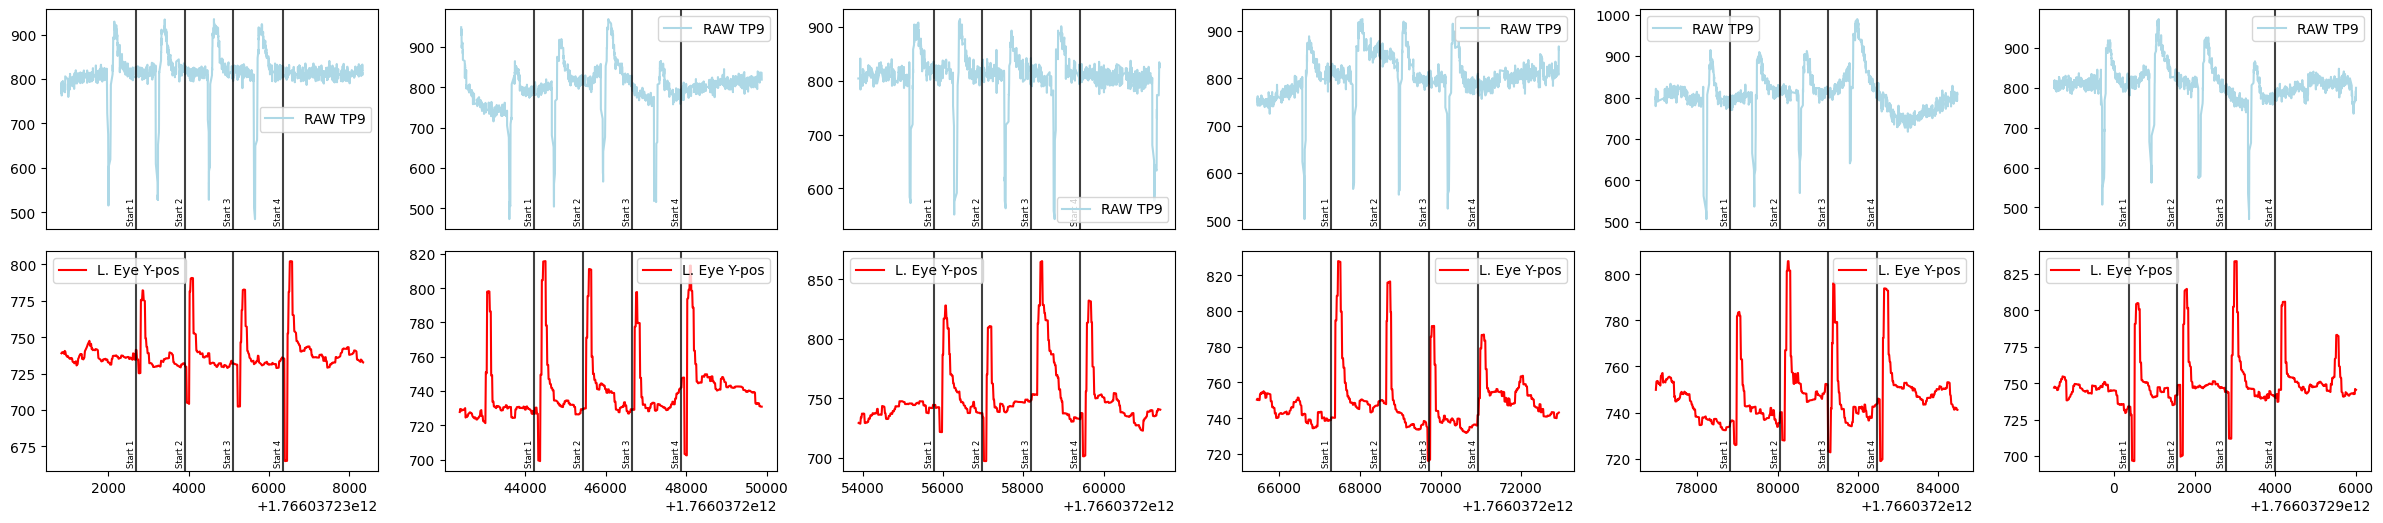

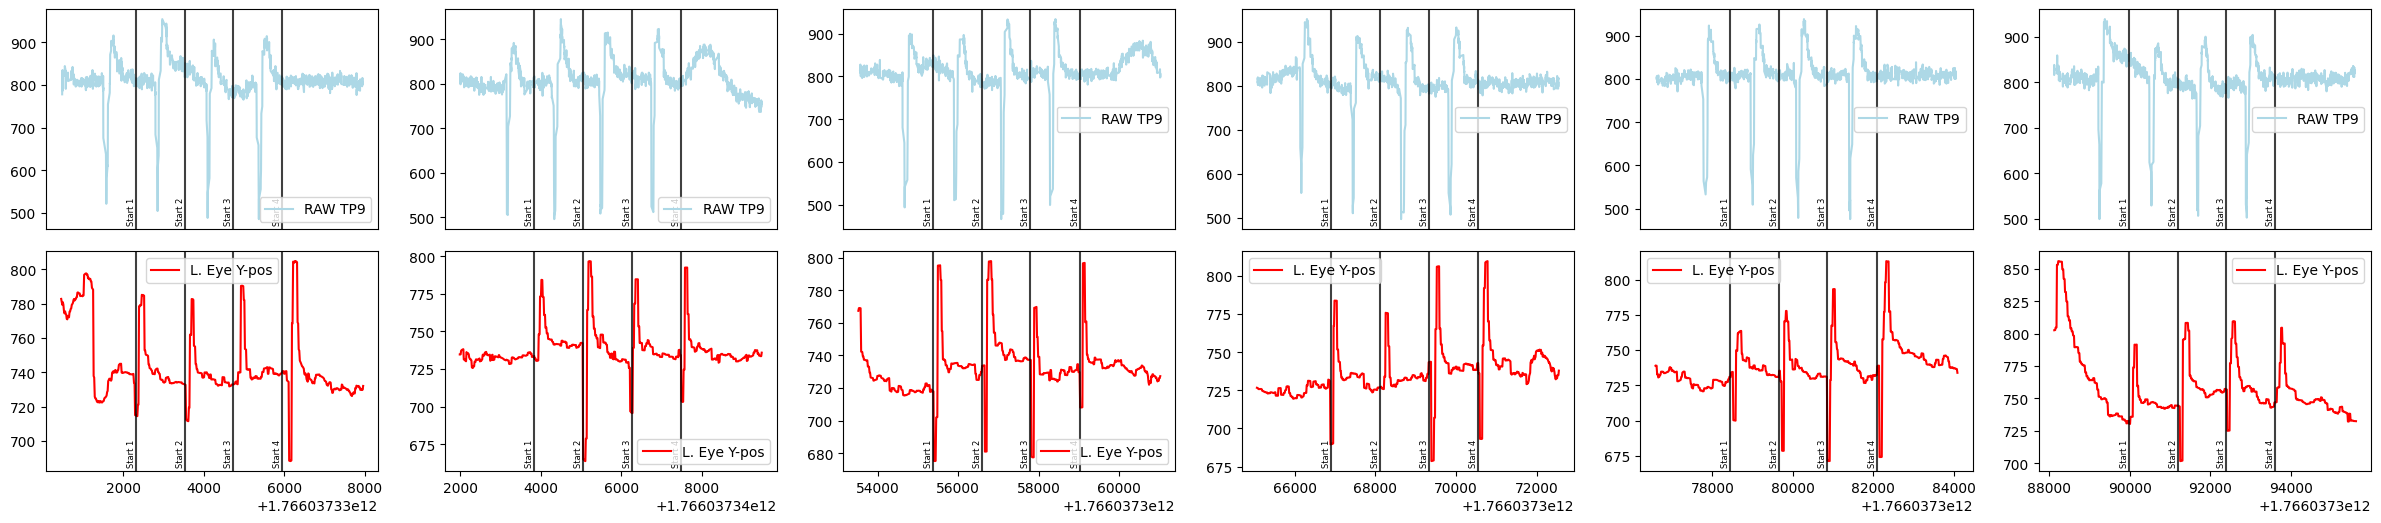

In [59]:
%matplotlib inline
plt.close()
for s in experiment.sessions:
    s.plot_raw_calibrations()

In [55]:
class PointSelector:
    def __init__(self, x, y, figsize, on_select=None):
        self.x = np.asarray(x)
        self.y = np.asarray(y)
        self.figsize = figsize
        self.idx = 0
        self.selected = None

        if on_select is not None and not callable(on_select):
            raise TypeError("on_select must be callable or None")
        self.on_select = on_select

        self.fig, self.ax = plt.subplots(figsize=self.figsize)
        self.ax.plot(self.x, self.y, "-o", alpha=0.3)

        # movable cursor
        self.marker, = self.ax.plot(
            self.x[self.idx],
            self.y[self.idx],
            "ro",
            markersize=10
        )

        self.cid = self.fig.canvas.mpl_connect(
            "key_press_event",
            self.on_key
        )

        self.update()

    def set_data(self, x, y):
        self.__init__(x, y, self.figsize, on_select=self.on_select)

    def set_callback(self, on_select=None):
        if on_select is not None and not callable(on_select):
            raise TypeError("on_select must be callable or None")
        self.on_select = on_select

    def update(self):
        self.marker.set_data(
            [self.x[self.idx]],
            [self.y[self.idx]]
        )
        self.ax.set_title(
            f"Index {self.idx} | x={self.x[self.idx]:.3f}, y={self.y[self.idx]:.3f}\n"
            "← / → move   Enter select"
        )
        self.fig.canvas.draw_idle()

    def on_key(self, event):
        if event.key == "left":
            self.idx = max(0, self.idx - 1)
            self.update()

        elif event.key == "right":
            self.idx = min(len(self.x) - 1, self.idx + 1)
            self.update()

        elif event.key == "enter":
            self.selected = (self.x[self.idx], self.y[self.idx])

            if self.on_select is not None:
                self.on_select(
                    x=self.x[self.idx],
                    y=self.y[self.idx],
                    index=self.idx,
                    selector=self
                )

    def close(self):
        # 🔑 stop listening for events
        self.fig.canvas.mpl_disconnect(self.cid)

        # optional: visually mark selection
        self.ax.plot(
            self.x[self.idx],
            self.y[self.idx],
            "go",
            markersize=12,
            zorder=5
        )
        self.fig.canvas.draw_idle()
    
        

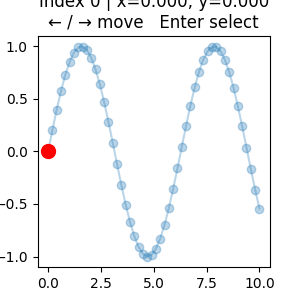

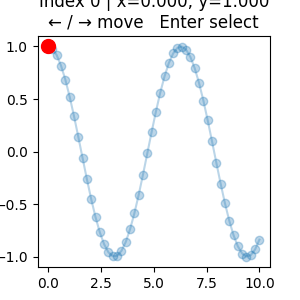

In [56]:
%matplotlib widget

x1 = np.linspace(0, 10, 50)
y1 = np.sin(x)
x2 = np.linspace(0, 10, 50)
y2 = np.cos(x)

selections = []
def print_selection(x, y, index, selector):
    print(f"Selected point {index}: ({x:.3f}, {y:.3f})")
    selections.append((index, x, y))
    selector.set_data(x2, y2)
    selector.set_callback(finalize_selection)

def finalize_selection(x, y, index, selector):
    print(f"Selected point {index}: ({x:.3f}, {y:.3f})")
    selections.append((index, x, y))
    selector.close()

selector = PointSelector(x1, y1, (3,3), on_select=print_selection)
plt.show()

selector.selected
#print("Final selection:", selector.selected)

In [ ]:
selector.selected


(np.float64(5.1020408163265305), np.float64(0.37986637199507933))

In [57]:
selections

[(0, np.float64(0.0), np.float64(0.0)), (0, np.float64(0.0), np.float64(1.0))]

In [ ]:
_ROOT_DIR = os.path.join('.','samples','blink_calibration','Android_1')

calibration_session = Calibration(_ROOT_DIR, 'eeg.csv', 'left_eye_gaze.csv', _CAL_FILES)

/var/folders/r7/zkk06b910nd7ysr86dhn0yqh0000gn/T/ipykernel_33531/1397362171.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.rename(columns=_EEG_RAW_COLNAMES, inplace=True)


[('0.25-72',
           unix_ms  frame  rel_timestamp    event  overlap_counter  ipd  \
  0  1766036390548    971       0.000000    Start                0   63   
  1  1766036396422   1393       5.870515  Overlap                1   63   
  2  1766036397633   1480       7.081645  Overlap                2   63   
  3  1766036398844   1567       8.293174  Overlap                3   63   
  4  1766036400041   1653       9.489820  Overlap                4   63   
  5  1766036402046   1797      11.494910      End                4   63   
  
      raw_fps  smooth_fps  conf_threshold  
  0  61.54517    62.48128            0.25  
  1  70.77061    71.33060            0.25  
  2  71.38740    71.81262            0.25  
  3  76.97334    74.41969            0.25  
  4  71.46472    71.62185            0.25  
  5  69.48238    69.70958            0.25  ),
 ('0.25-90',
           unix_ms  frame  rel_timestamp    event  overlap_counter  ipd  \
  0  1766036402074   1799       0.000000    Start            

,unix_sec,unix_ms,rel_sec,rel_ms,TP9,TP10,AF7,AF8
1,1.766036e+09,1766036381714,0.015,15,842.52747,828.82780,791.35530,799.01100
2,1.766036e+09,1766036381715,0.016,16,819.15753,822.38100,792.56410,794.17584
3,1.766036e+09,1766036381715,0.016,16,799.01100,823.99270,796.99634,795.38464
4,1.766036e+09,1766036381716,0.017,17,817.94870,821.57510,799.01100,802.23444
5,1.766036e+09,1766036381716,0.017,17,850.18317,824.39560,803.44324,805.05493
...,...,...,...,...,...,...,...,...
22467,1.766036e+09,1766036469313,87.614,87614,840.51280,860.65936,0.00000,1108.46150
22468,1.766036e+09,1766036469313,87.614,87614,841.31866,868.31500,0.00000,1119.74350
22469,1.766036e+09,1766036469313,87.614,87614,843.73627,867.10620,0.00000,1087.10620
22470,1.766036e+09,1766036469314,87.615,87615,850.58606,860.65936,0.00000,1036.33700
